# Appendix C

In [1]:
import sys
sys.path.append('/Users/kenzatazi/Documents/CDT/Code')

from load import beas_sutlej_gauges, era5, data_dir
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt

from tqdm import tqdm

import pandas as pd
import numpy as np
import GPy
import scipy as sp
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from mfdgp.utils.metrics import msll, r2_low_vs_high

In [2]:
import emukit
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

In [3]:
import pickle

## Prepare data

In [4]:
# Date range
minyear = 1980
maxyear = 2010

In [5]:
# Load cross-validation scheme
da = beas_sutlej_gauges.all_gauge_data(minyear, maxyear, threshold=365*30)
station_names = np.array(list(da))

 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:91: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
list(da)


['Pandoh', 'Banjar', 'Bhuntar', 'Larji', 'Suni', 'Rampur', 'Kasol', 'Bhakra']

In [7]:
# Split into five chunks
kf = KFold(n_splits=8)

cv_train_list = []
cv_test_list = []

for train_index, test_index in kf.split(station_names):
    hf_train, hf_test = station_names[train_index], station_names[test_index]
    cv_train_list.append(hf_train)
    cv_test_list.append(hf_test)

In [40]:
cv_train_list

[array(['Banjar', 'Bhuntar', 'Larji', 'Suni', 'Rampur', 'Kasol', 'Bhakra'],
       dtype='<U7'),
 array(['Pandoh', 'Bhuntar', 'Larji', 'Suni', 'Rampur', 'Kasol', 'Bhakra'],
       dtype='<U7'),
 array(['Pandoh', 'Banjar', 'Larji', 'Suni', 'Rampur', 'Kasol', 'Bhakra'],
       dtype='<U7'),
 array(['Pandoh', 'Banjar', 'Bhuntar', 'Suni', 'Rampur', 'Kasol', 'Bhakra'],
       dtype='<U7'),
 array(['Pandoh', 'Banjar', 'Bhuntar', 'Larji', 'Rampur', 'Kasol',
        'Bhakra'], dtype='<U7'),
 array(['Pandoh', 'Banjar', 'Bhuntar', 'Larji', 'Suni', 'Kasol', 'Bhakra'],
       dtype='<U7'),
 array(['Pandoh', 'Banjar', 'Bhuntar', 'Larji', 'Suni', 'Rampur', 'Bhakra'],
       dtype='<U7'),
 array(['Pandoh', 'Banjar', 'Bhuntar', 'Larji', 'Suni', 'Rampur', 'Kasol'],
       dtype='<U7')]

In [41]:
# Split data
cv_x_train_hf = []
cv_y_train_hf = []
cv_x_train_lf = []
cv_y_train_lf = []
cv_x_val = []
cv_y_val = []
lf_lambdas = []

for i in range(len(cv_train_list)):

    hf_train_list = []
    for station in cv_train_list[i]:
        station_ds = beas_sutlej_gauges.gauge_download(
            station, minyear=minyear, maxyear=maxyear)
        hf_train_list.append(station_ds.to_dataframe().dropna().reset_index())
    hf_train_df = pd.concat(hf_train_list)

    val_list = []
    for station in cv_test_list[i]:
        station_ds = beas_sutlej_gauges.gauge_download(
            station, minyear=minyear, maxyear=maxyear)
        val_list.append(station_ds.to_dataframe().dropna().reset_index())
    val_df = pd.concat(val_list)

    # era5.collect_ERA5('indus', minyear=minyear, maxyear=maxyear)
    era5_df = era5.gauges_download(
        list(cv_test_list[i]) + list(cv_train_list[i]), minyear=minyear, maxyear=maxyear)

    hf_train_df.sort_values(by='time', inplace=True)
    val_df.sort_values(by='time', inplace=True)
    lf_train_df = era5_df.sort_values(by='time')
    
    # Prepare data
    
    # Transformations
    lf_train_df['tp_tr'], lf_lambda = sp.stats.boxcox(
        lf_train_df['tp'].values + 0.01)
    hf_train_df['tp_tr'] = sp.stats.boxcox(
        hf_train_df['tp'].values + 0.01, lmbda=lf_lambda)
    val_df['tp_tr'] = sp.stats.boxcox(
        val_df['tp'].values + 0.01, lmbda=lf_lambda)

    # Splitting
    x_train_lf = lf_train_df[['time', 'lat', 'lon', 'z']].values.reshape(-1, 4)
    y_train_lf = lf_train_df['tp_tr'].values.reshape(-1, 1)
    x_train_hf = hf_train_df[['time', 'lat', 'lon', 'z']].values.reshape(-1, 4)
    y_train_hf = hf_train_df[['tp_tr']].values.reshape(-1, 1)
    x_val = val_df[['time', 'lat', 'lon', 'z']].values.reshape(-1, 4)
    y_val = val_df['tp_tr'].values.reshape(-1, 1)

    # Scaling
    scaler = StandardScaler().fit(x_train_hf)
    x_train_hf1 = scaler.transform(x_train_hf)
    x_train_lf1 = scaler.transform(x_train_lf)
    x_val1 = scaler.transform(x_val)
    
    cv_x_train_hf.append(x_train_hf1)
    cv_y_train_hf.append(y_train_hf)
    cv_x_train_lf.append(x_train_lf1)
    cv_y_train_lf.append(y_train_lf)
    cv_x_val.append(x_val1)
    cv_y_val.append(y_val)
    lf_lambdas.append(lf_lambda)


 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


indus
/Users/kenzatazi/Documents/CDT/Code/data/ERA5/combi_data_indus_03-2023.csv


 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


indus
/Users/kenzatazi/Documents/CDT/Code/data/ERA5/combi_data_indus_03-2023.csv


 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


indus
/Users/kenzatazi/Documents/CDT/Code/data/ERA5/combi_data_indus_03-2023.csv


 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


indus
/Users/kenzatazi/Documents/CDT/Code/data/ERA5/combi_data_indus_03-2023.csv


 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


indus
/Users/kenzatazi/Documents/CDT/Code/data/ERA5/combi_data_indus_03-2023.csv


 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


indus
/Users/kenzatazi/Documents/CDT/Code/data/ERA5/combi_data_indus_03-2023.csv


 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


indus
/Users/kenzatazi/Documents/CDT/Code/data/ERA5/combi_data_indus_03-2023.csv


 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
 /Users/kenzatazi/Documents/CDT/Code/load/beas_sutlej_gauges.py:34: FutureWarning:In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


indus
/Users/kenzatazi/Documents/CDT/Code/data/ERA5/combi_data_indus_03-2023.csv


In [28]:
np.array(cv_x_train_hf[0])


array([[-1.71767669,  0.53078931,  0.66383662,  1.48097508],
       [-1.71767669, -1.46405854, -0.03107639, -0.83487355],
       [-1.71767669,  1.25706887,  0.21453942, -0.24625436],
       ...,
       [ 1.71767669,  0.53078931,  0.66383662,  1.48097508],
       [ 1.71767669, -0.88787676, -0.71999877, -0.8219975 ],
       [ 1.71767669, -0.09865297,  0.30439886,  1.76976637]])

In [42]:
np.save('data/cv_x_train_hf_bs_1980-2010.npy', np.array(cv_x_train_hf))
np.save('data/cv_y_train_hf_bs_1980-2010.npy', np.array(cv_y_train_hf))
np.save('data/cv_x_train_lf_bs_1980-2010.npy', np.array(cv_x_train_lf))
np.save('data/cv_y_train_lf_bs_1980-2010.npy', np.array(cv_y_train_lf))
np.save('data/cv_y_val_bs_1980-2010.npy', np.array(cv_y_val))
np.save('data/cv_x_val_bs_1980-2010.npy', np.array(cv_x_val))
np.save('data/lf_lambda_1980-2010.npy', np.array(lf_lambdas))

## Load data

In [8]:
cv_x_train_hf = np.load('data/cv_x_train_hf_bs_1980-2010.npy', allow_pickle=True)
cv_y_train_hf = np.load('data/cv_y_train_hf_bs_1980-2010.npy', allow_pickle=True)
cv_x_train_lf = np.load('data/cv_x_train_lf_bs_1980-2010.npy', allow_pickle=True)
cv_y_train_lf = np.load('data/cv_y_train_lf_bs_1980-2010.npy', allow_pickle=True)
cv_x_val = np.load('data/cv_x_val_bs_1980-2010.npy', allow_pickle=True)
cv_y_val = np.load('data/cv_y_val_bs_1980-2010.npy', allow_pickle=True)
lf_lambdas = np.load('data/lf_lambda_1980-2010.npy', allow_pickle=True)

## MFDGP

In [9]:
R2_all = []

for t in tqdm([1, 2, 4, 8, 15, 30]):

    R2 = []

    for i in range(len(cv_train_list)):

        tr = 12 * t

        # Input data
        X_train, Y_train = convert_xy_lists_to_arrays([cv_x_train_lf[i][:tr], cv_x_train_hf[i][:tr]], [cv_y_train_lf[i][:tr], cv_y_train_hf[i][:tr]])

        # Train and evaluate
        kern1 = GPy.kern.Matern52(input_dim=4, ARD=True)
        kernels = [kern1, GPy.kern.Matern52(input_dim=4, ARD=True)]
        lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
        gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2,)
        gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(0)
        gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)
        lin_mf_model = GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=5)
        lin_mf_model.optimize()
        
        # Load and prep test data                                     
        x_val1, y_val = cv_x_val[i], cv_y_val[i]                                                                                   
        n = x_val1.shape[0]
        x_met = convert_x_list_to_array([x_val1, x_val1])
        
        # ALL
        y_pred0, y_var0 = lin_mf_model.predict(x_met[n:])
        y_pred_low0, y_var_low0 = lin_mf_model.predict(x_met[:n])
        
        y_pred = sp.special.inv_boxcox(y_pred0, lf_lambdas[i]).reshape(-1)
        y_true = sp.special.inv_boxcox(y_val, lf_lambdas[i]).reshape(-1)
        R2.append(r2_score(y_true, y_pred))
    
    print('Mean R2 = ', np.mean(R2), '±', np.std(R2))
    R2_all.append([np.mean(R2), np.std(R2)])

np.savetxt('app_c_ypred_lf_r2.npy', R2_all)

  0%|          | 0/6 [00:00<?, ?it/s] /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 7.022376651122922
Optimization restart 2/5, f = 7.0341989748807165
Optimization restart 3/5, f = 9.157347424510181
Optimization restart 4/5, f = 7.025504414262787
Optimization restart 5/5, f = 6.831177838090923


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 9.48307352235203
Optimization restart 2/5, f = 8.715707722546261
Optimization restart 3/5, f = 7.4909290378499485
Optimization restart 4/5, f = 7.490929974820922
Optimization restart 5/5, f = 17.24947044416062


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 4.5456245749819075
Optimization restart 2/5, f = 2.3907438368481344
Optimization restart 3/5, f = 14.171334670557862
Optimization restart 4/5, f = 4.545624533208361
Optimization restart 5/5, f = 3.4515906300025776


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 3.9323925254563488
Optimization restart 2/5, f = 5.808676847045875
Optimization restart 3/5, f = 3.9323923749790133
Optimization restart 4/5, f = 3.9323923117768587
Optimization restart 5/5, f = 5.7559171445231065


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 3.9466823140576945
Optimization restart 2/5, f = 3.946682418441412
Optimization restart 3/5, f = 7.980287023331638
Optimization restart 4/5, f = 3.9466821351122725
Optimization restart 5/5, f = 3.9466822111107867


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 0.8950956055689865
Optimization restart 2/5, f = 0.8950956254056166
Optimization restart 3/5, f = 0.8950954601663987
Optimization restart 4/5, f = 0.8950956176840137
Optimization restart 5/5, f = 0.8950955429635563


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 7.7533340541495335
Optimization restart 2/5, f = 7.753334164505375
Optimization restart 3/5, f = 7.96082295883642
Optimization restart 4/5, f = 11.930596815715376
Optimization restart 5/5, f = 7.75333401011172


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 7.445782564732182
Optimization restart 2/5, f = 6.834475006054243
Optimization restart 3/5, f = 6.834474838292575
Optimization restart 4/5, f = 7.499158433348374


 17%|█▋        | 1/6 [00:19<01:35, 19.05s/it]

Optimization restart 5/5, f = 7.633488686074605
Mean R2 =  -0.3930318958096898 ± 0.0823269199250866


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 5.108325563363728
Optimization restart 2/5, f = 5.108325941564068
Optimization restart 3/5, f = 7.188918360574682
Optimization restart 4/5, f = 6.023730442420316
Optimization restart 5/5, f = 6.05858685660634


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 3.9388101936811495
Optimization restart 2/5, f = 3.8324911220382276
Optimization restart 3/5, f = 147.39690215909508


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide


Optimization restart 4/5, f = 10.991129325896726
Optimization restart 5/5, f = 9.079169787237625


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 0.8453153328272478
Optimization restart 2/5, f = 5.558460864251202
Optimization restart 3/5, f = 0.5458785588223307
Optimization restart 4/5, f = 1.9176969894274265
Optimization restart 5/5, f = 1.671503891251497


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 5.007954887525905
Optimization restart 2/5, f = 5.069505166937343
Optimization restart 3/5, f = 4.896704416754275
Optimization restart 4/5, f = 4.957662674879252


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide
 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 5/5, f = 9.53095912034835
Optimization restart 1/5, f = 2.9615918319585646
Optimization restart 2/5, f = 2.460486232736848
Optimization restart 3/5, f = 3.876856569563685
Optimization restart 4/5, f = 3.6473983369846863
Optimization restart 5/5, f = 4.020903183772457


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 5.183759700792237
Optimization restart 2/5, f = 3.788865954630637
Optimization restart 3/5, f = 3.552079863688025
Optimization restart 4/5, f = 4.038366928673128
Optimization restart 5/5, f = 5.130699708159597


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 8.39218214792712
Optimization restart 2/5, f = 7.730723020499035
Optimization restart 3/5, f = 10.725159055051048
Optimization restart 4/5, f = 8.611347929331576
Optimization restart 5/5, f = 6.804040158227032


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 8.753841819249647
Optimization restart 2/5, f = 7.890590569354398
Optimization restart 3/5, f = 8.784004723576516
Optimization restart 4/5, f = 7.6115408615426645


 33%|███▎      | 2/6 [00:33<01:05, 16.28s/it]

Optimization restart 5/5, f = 8.320306870699035
Mean R2 =  -0.39214300713863603 ± 0.08077638204701579


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 66.93367068250198
Optimization restart 2/5, f = 66.772223739624
Optimization restart 3/5, f = 66.77222474742531
Optimization restart 4/5, f = 66.77222319379959
Optimization restart 5/5, f = 66.93367107395828


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 65.80413725467315
Optimization restart 2/5, f = 87.13853871348076
Optimization restart 3/5, f = 65.80413624787292
Optimization restart 4/5, f = 65.80413885280225
Optimization restart 5/5, f = 66.28322187805827


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 67.38512001029015
Optimization restart 2/5, f = 67.38511207370966
Optimization restart 3/5, f = 72.484748422759
Optimization restart 4/5, f = 268028979.00112137
Optimization restart 5/5, f = 67.3851105901791


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 69.73452887303263
Optimization restart 2/5, f = 69.73452847013004
Optimization restart 3/5, f = 69.73453139387667
Optimization restart 4/5, f = 69.73452974657268
Optimization restart 5/5, f = 69.7345306249384


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 65.99341210073933
Optimization restart 2/5, f = 64.94075457195032
Optimization restart 3/5, f = 64.94075823147367
Optimization restart 4/5, f = 65.99030153297335
Optimization restart 5/5, f = 65.32006021890221


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 61.6284946708199
Optimization restart 2/5, f = 61.628494759899155
Optimization restart 3/5, f = 61.62849438417122
Optimization restart 4/5, f = 61.628504769666755
Optimization restart 5/5, f = 61.62849571663004


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 68.92647857667716
Optimization restart 2/5, f = 68.92647899734465
Optimization restart 3/5, f = 68.09362398728058
Optimization restart 4/5, f = 68.92647847846658
Optimization restart 5/5, f = 68.13217815694091


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 65.78058431954715
Optimization restart 2/5, f = 65.78059317698288
Optimization restart 3/5, f = 70.5569902127154
Optimization restart 4/5, f = 65.78058625144365


 50%|█████     | 3/6 [01:02<01:07, 22.34s/it]

Optimization restart 5/5, f = 65.78058247401813
Mean R2 =  -0.37599113985067056 ± 0.08653803600285713


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 138.58828653541067
Optimization restart 2/5, f = 138.58828685741378
Optimization restart 3/5, f = 138.58828785728826
Optimization restart 4/5, f = 138.58828864420133
Optimization restart 5/5, f = 138.58828594935653


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 136.94613171636416
Optimization restart 2/5, f = 136.94613094178385
Optimization restart 3/5, f = 136.94613088256563
Optimization restart 4/5, f = 136.72811806581677
Optimization restart 5/5, f = 151.9833793611739


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 140.72654716395772
Optimization restart 2/5, f = 140.72654687432237
Optimization restart 3/5, f = 140.20593148409017
Optimization restart 4/5, f = 140.20593138015428
Optimization restart 5/5, f = 215.97587303062363


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 143.95363600249726
Optimization restart 2/5, f = 143.9536367532149
Optimization restart 3/5, f = 143.95363963191357
Optimization restart 4/5, f = 143.95363290444067
Optimization restart 5/5, f = 143.95363297134105


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 147.7244940201193
Optimization restart 2/5, f = 137.49124243429006
Optimization restart 3/5, f = 137.4912427343101
Optimization restart 4/5, f = 172.03554233894124
Optimization restart 5/5, f = 137.49124495131127


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 136.7798249692909
Optimization restart 2/5, f = 136.77981227226462
Optimization restart 3/5, f = 136.77981757372874
Optimization restart 4/5, f = 136.77981239152209
Optimization restart 5/5, f = 136.779811345172


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 149.23640482966013
Optimization restart 2/5, f = 141.65735961191288
Optimization restart 3/5, f = 149.59143210237687
Optimization restart 4/5, f = 141.65738066871432
Optimization restart 5/5, f = 141.65737647798392


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 141.73343443627624
Optimization restart 2/5, f = 141.73342808560625
Optimization restart 3/5, f = 141.73342629654343
Optimization restart 4/5, f = 141.73344826235615


 67%|██████▋   | 4/6 [01:52<01:05, 32.89s/it]

Optimization restart 5/5, f = 143.34966355219103
Mean R2 =  -0.37340592305817677 ± 0.08739104979392062


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 338.1901388495419
Optimization restart 2/5, f = 338.1901793298882
Optimization restart 3/5, f = 325.97749166123833
Optimization restart 4/5, f = 336.04945958425805
Optimization restart 5/5, f = 338.19018102923394


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 368.15096044041013
Optimization restart 2/5, f = 347.7069775944948
Optimization restart 3/5, f = 383.85714119813815
Optimization restart 4/5, f = 368.126049650663
Optimization restart 5/5, f = 376.8601844431664


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 362.03262936860324
Optimization restart 2/5, f = 373.02760064896415
Optimization restart 3/5, f = 362.0326241678978
Optimization restart 4/5, f = 382.0846737254173
Optimization restart 5/5, f = 371.3075708518911


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 376.85815190984806
Optimization restart 2/5, f = 358.59588754665094
Optimization restart 3/5, f = 365.9824455437648
Optimization restart 4/5, f = 358.59581131273995
Optimization restart 5/5, f = 358.5958103073238


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 367.9495865914606
Optimization restart 2/5, f = 367.08641969811356
Optimization restart 3/5, f = 362.153239620708
Optimization restart 4/5, f = 362.26230544524674
Optimization restart 5/5, f = 369.73767385551076


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 360.4193386100348
Optimization restart 2/5, f = 355.1009795947233
Optimization restart 3/5, f = 363.1349313940332
Optimization restart 4/5, f = 355.1009629646697
Optimization restart 5/5, f = 360.89047849495165


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 353.33355183938363
Optimization restart 2/5, f = 353.33355198584434
Optimization restart 3/5, f = 353.3335510495757
Optimization restart 4/5, f = 365.2425156458577
Optimization restart 5/5, f = 361.05987694836756


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 364.78122356577205
Optimization restart 2/5, f = 349.6763074835691
Optimization restart 3/5, f = 375.22092922044374
Optimization restart 4/5, f = 349.6763118845032


 83%|████████▎ | 5/6 [03:35<00:58, 58.32s/it]

Optimization restart 5/5, f = 349.6763247014747
Mean R2 =  -0.3969580476901406 ± 0.18277009538489272


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 695.4642350679876
Optimization restart 2/5, f = 707.0437832205076
Optimization restart 3/5, f = 680.9718874270649
Optimization restart 4/5, f = 701.4185762945915
Optimization restart 5/5, f = 704.0498175546724


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 692.2016268959849
Optimization restart 2/5, f = 715.475137951882
Optimization restart 3/5, f = 696.2032647590988
Optimization restart 4/5, f = 696.2032650194458
Optimization restart 5/5, f = 696.2032747296557


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 722.0673449501742
Optimization restart 2/5, f = 718.7352724110834
Optimization restart 3/5, f = 723.0440342401894
Optimization restart 4/5, f = 738.3297096340561
Optimization restart 5/5, f = 731.7398578774602


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 727.3887915331567
Optimization restart 2/5, f = 723.9041742437001
Optimization restart 3/5, f = 719.1365506855611
Optimization restart 4/5, f = 725.2443449708644
Optimization restart 5/5, f = 726.4900487247345


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 689.6649419076286
Optimization restart 2/5, f = 689.6649468089511
Optimization restart 3/5, f = 689.6649408605044
Optimization restart 4/5, f = 718.122869271689
Optimization restart 5/5, f = 689.6649396534938


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 692.0497132444153
Optimization restart 2/5, f = 696.7800614519864
Optimization restart 3/5, f = 702.5685612553671
Optimization restart 4/5, f = 722.418092408924
Optimization restart 5/5, f = 692.0497172362418


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 661.8674860902775
Optimization restart 2/5, f = 661.8674840777735
Optimization restart 3/5, f = 749.8870320932295
Optimization restart 4/5, f = 661.8674959315906
Optimization restart 5/5, f = 661.8674817654269


 /Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/5, f = 686.8221188441386
Optimization restart 2/5, f = 692.2313796545959
Optimization restart 3/5, f = 697.1241231711949
Optimization restart 4/5, f = 686.8221469721033


100%|██████████| 6/6 [10:08<00:00, 101.45s/it]

Optimization restart 5/5, f = 710.7386070496791
Mean R2 =  -0.3445948234637437 ± 0.1472861254875015


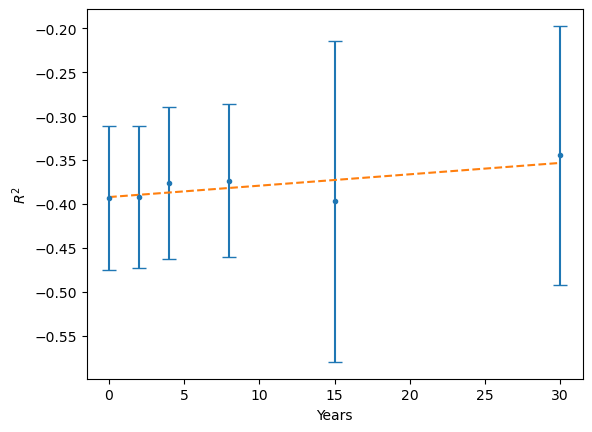

In [17]:
plt.figure()
R2_arr = np.array(R2_all)
plt.errorbar([0, 2, 4, 8, 15, 30], R2_arr[:,0], yerr=R2_arr[:,1], capsize=5, marker='.', linestyle='none')
reg = LinearRegression().fit(np.array([0, 2, 4, 8, 15, 30]).reshape(-1,1), R2_arr[:, 0])
y = reg.predict(np.linspace(0, 30, 10).reshape(-1, 1))
plt.plot(np.linspace(0,30,10).reshape(-1,1), y, linestyle='--')
plt.ylabel('$R^2$')
plt.xlabel('Years')
plt.savefig('appendix_C_plot.png', dpi=300)